# Final Project: Music Genre Clustering

In [24]:
# the following packages can be used to extract features from audio data
from pyAudioAnalysis import audioBasicIO as abio
from pyAudioAnalysis import ShortTermFeatures as stf
from pydub import AudioSegment
import librosa
import librosa.display
# you may use other packages too.
import os,glob,eyed3
import pandas as pd
import numpy as np


from sklearn import cluster


pd.set_option('display.max_columns', None)


import matplotlib.pyplot as plt

Please use the given data (including the sound tracks and an additional feature file) to cluster the sound tracks. You may use any methods for feature engineering, but the clustering methods should be limited to the methods in this class. Do not hand label the tracks. Then generate the submission.json file for submission purposes. 

In [6]:
cw = os.getcwd()
os.listdir(cw)

data = cw + '/data'
fils = os.listdir(data)
fils = tuple(fils)

In [28]:
feats = pd.read_csv('feature_set.csv',header=[0,1,2])
feats = feats.set_index(feats.columns[0])

In [33]:
feats['chroma_cens']

0.729950 -0.805870 -0.795872 -0.002026   
4                             -0.597592  0.610723 -0.406698  0.031583   
...                                 ...       ...       ...       ...   
85                            -0.295000  0.020247 -0.383799 -0.089401   
86                            -0.254850  0.701667 -1.101793 -1.015899   
87                            -0.576097 -0.480972 -1.117766  0.475257   
88                             0.588360 -0.404090  0.666972  0.817534   
89                            -0.728301  0.519564  0.205120 -0.842308   

                                                                       \
                                     09        10        11        12   
(feature, statistics, number)                                           
0                              1.700059  0.133831 -0.989182 -0.617790   
1                              0.422103 -0.051525  0.268163  0.455092   
2                             -0.656558  0.132843 -0.573856  2.503376   
3                             -0.517309 -0.849433 -0.921587  3.064209   
4                             -0.253484 -0.050135  0.695594 -0.754319   
...                                 ...       ...       ...       ...   
85                            -0.135325  0.651826 -0.537588 -0.774158   
86                            -1.168807  1.059893 -0.200050  2.158769   
87                            -1.103677 -0.125222 -0.794122 -1.243121   
88                            -0.891178 -0.849103  3.533587  0.539222   
89                            -1.125524 -0.139352 -0.963818 -1.108550   

                                    max                                \
                                     01        02        03        04   
(feature, statistics, number)                                           
0                              0.686195  0.642466  0.660841  0.622677   
1                              0.721947  0.512168  0.545834  0.584512   
2                              0.659792  0.599739  0.687972  0.502656   
3                              0.693670  0.640284  0.712163  0.535815   
4                              0.653399  0.563665  0.539257  0.519335   
...                                 ...       ...       ...       ...   
85                             0.577522  0.603911  0.477923  0.571671   
86                             0.640390  0.659964  0.697971  0.568670   
87                             0.635256  0.692013  0.663766  0.578364   
88                             0.585890  0.646570  0.591808  0.497059   
89                             0.630967  0.565458  0.546404  0.653011   

                                                                       \
                                     05        06        07        08   
(feature, statistics, number)                                           
0                              0.547088  0.546332  0.642207  0.648337   
1                              0.546567  0.622897  0.642696  0.614520   
2                              0.544360  0.635382  0.575710  0.646890   
3                              0.647889  0.654627  0.627237  0.670979   
4                              0.542269  0.467284  0.483408  0.632589   
...                                 ...       ...       ...       ...   
85                             0.698699  0.551529  0.693218  0.568223   
86                             0.571022  0.669144  0.593137  0.710201   
87                             0.683069  0.570267  0.638338  0.688016   
88                             0.478615  0.496218  0.580543  0.527495   
89                             0.565918  0.680929  0.525199  0.602808   

                                                                       \
                                     09        10        11        12   
(feature, statistics, number)                                           
0                              0.666268  0.671629  0.680681  0.637194   
1                              0.654118  0.630615  0.705118  0.664513   
2           

In [22]:
y, sr = librosa.load(librosa.util.example_audio_file(), offset=10, duration=15)
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_chroma=12, n_fft=4096)
chroma_cq = librosa.feature.chroma_cqt(y=y, sr=sr)

In [13]:
y.shape

(330750,)

In [27]:
chroma_cq.shape

(12, 646)

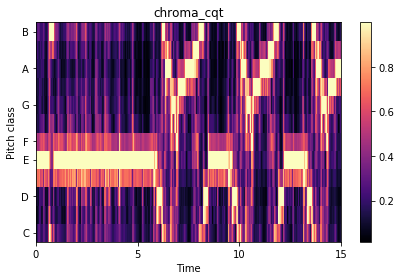

In [25]:
librosa.display.specshow(chroma_cq, y_axis='chroma', x_axis='time')
plt.title('chroma_cqt')
plt.colorbar()
plt.tight_layout()
plt.show()

In [39]:
feats['chroma_cens']

0.729950 -0.805870 -0.795872 -0.002026   
4                             -0.597592  0.610723 -0.406698  0.031583   
...                                 ...       ...       ...       ...   
85                            -0.295000  0.020247 -0.383799 -0.089401   
86                            -0.254850  0.701667 -1.101793 -1.015899   
87                            -0.576097 -0.480972 -1.117766  0.475257   
88                             0.588360 -0.404090  0.666972  0.817534   
89                            -0.728301  0.519564  0.205120 -0.842308   

                                                                       \
                                     09        10        11        12   
(feature, statistics, number)                                           
0                              1.700059  0.133831 -0.989182 -0.617790   
1                              0.422103 -0.051525  0.268163  0.455092   
2                             -0.656558  0.132843 -0.573856  2.503376   
3                             -0.517309 -0.849433 -0.921587  3.064209   
4                             -0.253484 -0.050135  0.695594 -0.754319   
...                                 ...       ...       ...       ...   
85                            -0.135325  0.651826 -0.537588 -0.774158   
86                            -1.168807  1.059893 -0.200050  2.158769   
87                            -1.103677 -0.125222 -0.794122 -1.243121   
88                            -0.891178 -0.849103  3.533587  0.539222   
89                            -1.125524 -0.139352 -0.963818 -1.108550   

                                    max                                \
                                     01        02        03        04   
(feature, statistics, number)                                           
0                              0.686195  0.642466  0.660841  0.622677   
1                              0.721947  0.512168  0.545834  0.584512   
2                              0.659792  0.599739  0.687972  0.502656   
3                              0.693670  0.640284  0.712163  0.535815   
4                              0.653399  0.563665  0.539257  0.519335   
...                                 ...       ...       ...       ...   
85                             0.577522  0.603911  0.477923  0.571671   
86                             0.640390  0.659964  0.697971  0.568670   
87                             0.635256  0.692013  0.663766  0.578364   
88                             0.585890  0.646570  0.591808  0.497059   
89                             0.630967  0.565458  0.546404  0.653011   

                                                                       \
                                     05        06        07        08   
(feature, statistics, number)                                           
0                              0.547088  0.546332  0.642207  0.648337   
1                              0.546567  0.622897  0.642696  0.614520   
2                              0.544360  0.635382  0.575710  0.646890   
3                              0.647889  0.654627  0.627237  0.670979   
4                              0.542269  0.467284  0.483408  0.632589   
...                                 ...       ...       ...       ...   
85                             0.698699  0.551529  0.693218  0.568223   
86                             0.571022  0.669144  0.593137  0.710201   
87                             0.683069  0.570267  0.638338  0.688016   
88                             0.478615  0.496218  0.580543  0.527495   
89                             0.565918  0.680929  0.525199  0.602808   

                                                                       \
                                     09        10        11        12   
(feature, statistics, number)                                           
0                              0.666268  0.671629  0.680681  0.637194   
1                              0.654118  0.630615  0.705118  0.664513   
2           

In [1]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
data = feats

# feats['chroma_cens']feats['chroma_cens']
# cluster1 index1 index 55 ..
# cluster2 index 4, index 66 ...


#feats['mfcc']
#index1 index1 index 55 ..


scaler = StandardScaler()
x = scaler.fit_transform(data)


from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pc = pca.fit_transform(x)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(pc)
kmlabels = kmeans.labels_
kmdat = pd.DataFrame(data = pc, columns = ['z1','z2'])
kmdat['cluster'] = kmlabels
sns.lmplot('z1','z2', data = kmdat, hue = 'cluster', fit_reg = False)





NameError: name 'feats' is not defined

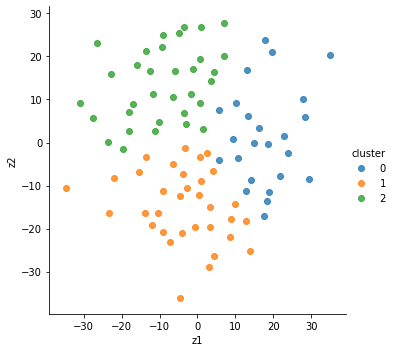

In [70]:
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.manifold import MDS
data = feats
scaler = StandardScaler()
x = scaler.fit_transform(data)


mds = MDS(n_components=2)
mds_trans = mds.fit_transform(x)
mds_trans = pd.DataFrame(mds_trans, columns = ['z1', 'z2'])


from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(mds_trans)
kmlabels = kmeans.labels_
kmdat = pd.DataFrame(data = mds_trans, columns = ['z1','z2'])
kmdat['cluster'] = kmlabels
sns.lmplot('z1','z2', data = kmdat, hue = 'cluster', fit_reg = False)

In [ ]:
class cluster2d:
    def __init__(self,dat,reduction,cluster)
        self.reduction = 'pca'
        self.cluster = 'kmeans'
        self.data = dat
        self.rdata = 0
    
    def stand(self):
        scaler = StandardScaler()
        self.data = scaler.fit_transform(data)
        
    def reduce(self):

        self.stand()

        if self.cluster == 'pca':
            from sklearn.decomposition import PCA
            pca = PCA(n_components=2)
            self.rdata = pca.fit_transform(x)
            pass
        elif self.cluster == 'mds':
            mds = MDS(n_components=2)
            mds_trans = mds.fit_transform(x)
            self.rdata = pd.DataFrame(mds_trans, columns = ['z1', 'z2'])
            pass
        
        elif self.cluster == 'lle'
            from sklearn.manifold import LocallyLinearEmbedding
            lle = LocallyLinearEmbedding(n_components=2,n_neighbors = 15,method='modified', eigen_solver = 'arpack',random_state=6)
            lle_trans = lle.fit_transform(dat5)
            self.rdata = pd.DataFrame(lle_trans, columns = ['z1', 'z2'])
            pass
        else:
            return('not available')

        def clusterme(self)
            if self.cluster == 'dbscan':
                pass
            elif self.cluster == 'kmeans':
                pass
            elif self.cluster == ''
            


In [4]:
rows = feats.columns.tolist()
feature = [i[0] for i in rows][1:]
statistics = [i[1] for i in rows][1:]

# unique column name values
feature_set = list(set(feature))
statistics_set = list(set(statistics))

print("Sets of headers:")
print(feature_set)
print()
print(statistics_set)

Sets of headers:
['spectral_bandwidth', 'mfcc', 'chroma_stft', 'spectral_rolloff', 'chroma_cens', 'tonnetz', 'spectral_contrast', 'spectral_centroid', 'zcr', 'chroma_cqt', 'rmse']

['mean', 'std', 'min', 'kurtosis', 'skew', 'max', 'median']


In [4]:
#read in and enable mp3 play
AudioSegment.from_file("data/2.mp3")

FileNotFoundError: [Errno 2] No such file or directory: 'ffprobe': 'ffprobe'

In [298]:
#https://gitlab.cs.dartmouth.edu/cy/show_and_tell/blob/d8dae9870895e1afe431360db729e2de597799b6/emotion/pyAudioAnalysis-master/audioBasicIO.py
[Fs,x] = audioBasicIO.read_audio_file("data/0.mp3")

In [259]:
#This function converts the input signal (stored in a numpy array) to MONO (if it is STEREO)
audioBasicIO.stereo_to_mono(x)

array([   0. ,    0. ,    0. , ..., 1803.5, 1445.5, 1327. ])

In [294]:
def convertDirMP3ToWav(dirName, Fs, nC, useMp3TagsAsName = False):
    '''
    This function converts the MP3 files stored in a folder to WAV. If required, the output names of the WAV files are based on MP3 tags, otherwise the same names are used.
    ARGUMENTS:
     - dirName:     the path of the folder where the MP3s are stored
     - Fs:          the sampling rate of the generated WAV files
     - nC:          the number of channesl of the generated WAV files
     - useMp3TagsAsName:    True if the WAV filename is generated on MP3 tags
    '''

    types = (dirName+os.sep+'*.mp3',) # the tuple of file types
    print(types)
    filesToProcess = [] 

    for files in types:
        filesToProcess.extend(glob.glob(files))     

    for f in filesToProcess:
        #tag.link(f)
        audioFile = eyed3.load(f)     
        #print(audioFile)
        if useMp3TagsAsName and audioFile.tag != None:          
            artist = audioFile.tag.artist
            title = audioFile.tag.title
            if artist!=None and title!=None:
                if len(title)>0 and len(artist)>0:
                    wavFileName = ntpath.split(f)[0] + os.sep + artist.replace(","," ") + " --- " + title.replace(","," ") + ".wav"
                else:
                    wavFileName = f.replace(".mp3",".wav")  
            else:
                wavFileName = f.replace(".mp3",".wav")                      
        else:
            wavFileName = f.replace(".mp3",".wav")      
        command = "avconv -i \"" + f + "\" -ar " +str(Fs) + " -ac " + str(nC) + " \"" + wavFileName + "\"";
        print (command)
        #os.system(command.encode('ascii','ignore').replace("\0",""))


In [295]:
convertDirMP3ToWav("data",44.1,1)

('data/*.mp3',)
avconv -i "data/82.mp3" -ar 44.1 -ac 1 "data/82.wav"
avconv -i "data/69.mp3" -ar 44.1 -ac 1 "data/69.wav"
avconv -i "data/41.mp3" -ar 44.1 -ac 1 "data/41.wav"
avconv -i "data/55.mp3" -ar 44.1 -ac 1 "data/55.wav"
avconv -i "data/7.mp3" -ar 44.1 -ac 1 "data/7.wav"
avconv -i "data/54.mp3" -ar 44.1 -ac 1 "data/54.wav"
avconv -i "data/6.mp3" -ar 44.1 -ac 1 "data/6.wav"
avconv -i "data/40.mp3" -ar 44.1 -ac 1 "data/40.wav"
avconv -i "data/68.mp3" -ar 44.1 -ac 1 "data/68.wav"
avconv -i "data/83.mp3" -ar 44.1 -ac 1 "data/83.wav"
avconv -i "data/81.mp3" -ar 44.1 -ac 1 "data/81.wav"
avconv -i "data/4.mp3" -ar 44.1 -ac 1 "data/4.wav"
avconv -i "data/56.mp3" -ar 44.1 -ac 1 "data/56.wav"
avconv -i "data/42.mp3" -ar 44.1 -ac 1 "data/42.wav"
avconv -i "data/43.mp3" -ar 44.1 -ac 1 "data/43.wav"
avconv -i "data/5.mp3" -ar 44.1 -ac 1 "data/5.wav"
avconv -i "data/57.mp3" -ar 44.1 -ac 1 "data/57.wav"
avconv -i "data/80.mp3" -ar 44.1 -ac 1 "data/80.wav"
avconv -i "data/84.mp3" -ar 44.1 -ac 1

## Submission to leaderboard

In [ ]:
# put your clustering result in labels
# if you have k clusters, the labels should be a vector of elements taking values
# from 0~ k-1

import json

submission = {}

# change this to the url, which I will hand out later.
submission['url'] = "http://127.0.0.1:8384"

# change this to your group id, which I will hand out later.
submission['vsID'] = " " 

submission['number_of_clusters'] = len(set(labels ))
submission['labels'] = []
for x in labels:
    submission['labels'].append( int(x) )

with open('submission.json', 'w') as outfile:
    json.dump(submission, outfile)


I will provide a submission tutorial session early next week. 